# Script 30 Script 27b network preparation

This notebook is used prepare the OSMnx network with Santiago's team pje_ep (Public space quality index) data.

Steps:
* The OSMnx network for the area of study was sent to Santiago's team and recieved with pje_ep.
* The recieved network is preformated
* The edges which would have changes for each project/strategy are identified and if necessary drawn in GIS.
* The nodes and preprocessed edges are uploaded to the database
* Function aup.graph_from_hippo is tested after implementing it in Script 27b

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from shapely import Point

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [3]:
# Saving appliable to each step
save = True
# CRS to be used if projecting
projected_crs = "EPSG:32719"

## a) Send to Santiago team OSMnx network to specific area of study

In [4]:
# aoi
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
city = 'alamedabuffer_4500m'

query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(aoi_gdf.crs)

epsg:4326


<Axes: >

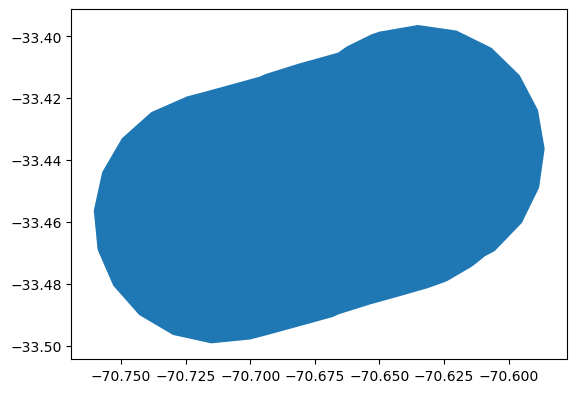

In [5]:
aoi_gdf.plot()

In [6]:
# osmnx_network
network_schema = 'projects_research'
nodes_table = 'santiago_nodes'
edges_table = 'santiago_edges'

G, nodes, edges = aup.graph_from_hippo(aoi_gdf, schema=network_schema, edges_folder=edges_table, nodes_folder=nodes_table, projected_crs=projected_crs)
print(nodes.crs)
print(edges.crs)

EPSG:4326
EPSG:4326


In [11]:
print(nodes.shape)
nodes.head(1)

(43734, 4)


,x,y,street_count,geometry
osmid,,,,
386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)


In [12]:
print(edges.shape)
edges.head(1)

(114163, 15)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
u,v,key,,,,,,,,,,,,,,,
13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,"LINESTRING (-70.73850 -33.49002, -70.73804 -33...",None,None,None,None,None,None,None


In [27]:
output_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/00_osmnx_nodata/"

In [10]:
if save:
    nodes.to_file(output_dir + f"nodes_buffer4500m.gpkg", driver='GPKG')
    edges.to_file(output_dir + f"edges_buffer4500m.gpkg", driver='GPKG')

## b) Analyse and format recieved network with pje_ep

Recieved data

In [4]:
recieved_data_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/01_osmnx_pje_ep/"
recieved_data = gpd.read_file(recieved_data_dir + "red_TEC_c_ptjeEP_2.shp")

# Show
print(recieved_data.crs)
print(recieved_data.shape)
recieved_data.head(2)

EPSG:4326
(123073, 3)


,fid,pje_ep,geometry
0,1.0,0.893827,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."
1,2.0,0.440809,"LINESTRING (-70.72370 -33.48910, -70.72352 -33..."


#### Recieved data doesn't have original edges cols. Merge.

In [5]:
osmnx_nodata_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/00_osmnx_nodata/"
edges = gpd.read_file(osmnx_nodata_dir + "edges_buffer4500m.gpkg")

# Show
print(edges.crs)
print(edges.shape)
edges.head(2)

EPSG:4326
(114163, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."
1,15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None,"LINESTRING (-70.72370 -33.48910, -70.72352 -33..."


In [6]:
osmnx_pje_ep = pd.merge(recieved_data,edges,on='geometry')

# Show
print(osmnx_pje_ep.crs)
print(osmnx_pje_ep.shape)
osmnx_pje_ep.head(2)

EPSG:4326
(123089, 20)


,fid,pje_ep,geometry,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service
0,1.0,0.893827,"LINESTRING (-70.73850 -33.49002, -70.73804 -33...",13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None
1,2.0,0.440809,"LINESTRING (-70.72370 -33.48910, -70.72352 -33...",15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None


### Why are there more edges in recieved data (123,073) than in edges original file(114,163)?

In [7]:
edges.loc[edges.duplicated(subset=['u','v','key','osmid'],keep=False)]

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry


In [8]:
osmnx_pje_ep.loc[osmnx_pje_ep.duplicated(subset=['u','v','key','osmid'],keep=False)].head(2)

,fid,pje_ep,geometry,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service
30,31.0,0.20477,"LINESTRING (-70.73794 -33.46278, -70.73794 -33...",253282676,4763027462,0,1287581726,True,3,Avenida Teniente Cruz,primary,50,4.667,None,None,None,None,None,None,None
31,31.0,0.20477,"LINESTRING (-70.73794 -33.46278, -70.73794 -33...",253282676,4763027462,0,1287581726,True,3,Avenida Teniente Cruz,primary,50,4.667,None,None,None,None,None,None,None


In [9]:
print(len(osmnx_pje_ep.loc[osmnx_pje_ep.u.isna()]))
print(len(osmnx_pje_ep.loc[osmnx_pje_ep.v.isna()]))
print(len(osmnx_pje_ep.loc[osmnx_pje_ep.key.isna()]))
print(len(osmnx_pje_ep.loc[osmnx_pje_ep.geometry.isna()]))
print(len(osmnx_pje_ep.loc[osmnx_pje_ep.pje_ep.isna()]))

0
0
0
0
0


### __Duplicated u,v,key and osmid would generate network problems. Examine in QGIS.__

In [11]:
examine = osmnx_pje_ep.loc[osmnx_pje_ep.duplicated(subset=['u','v','key','osmid'],keep=False)]
if save:
    examine.to_file(recieved_data_dir + f"osmnx_pje_ep_duplicates.gpkg", driver='GPKG')

#### __Result:__ Duplicated lines have the same u,v,key,osmid and pje_ep values. Dropping dupplicates on that subset resulted in the right amount of edges.

In [24]:
# After examination:
osmnx_pje_ep_f = osmnx_pje_ep.drop_duplicates(subset=['u','v','key','osmid','pje_ep'])

# Show
print(osmnx_pje_ep_f.shape)
osmnx_pje_ep_f.head(2)

(114163, 20)


,fid,pje_ep,geometry,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service
0,1.0,0.893827,"LINESTRING (-70.73850 -33.49002, -70.73804 -33...",13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None
1,2.0,0.440809,"LINESTRING (-70.72370 -33.48910, -70.72352 -33...",15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None


In [25]:
# Reset index and drop unordered index and fid
osmnx_pje_ep_f = osmnx_pje_ep_f.reset_index()
osmnx_pje_ep_f.drop(columns=['index','fid'],inplace=True)
# Reset index again to have a col named 'index' with a unique id for each line
osmnx_pje_ep_f = osmnx_pje_ep_f.reset_index()
osmnx_pje_ep_f.rename(columns={'index':'line_id'},inplace=True)
# Show
print(osmnx_pje_ep_f.shape)
osmnx_pje_ep_f.head(2)

(114163, 20)


,line_id,pje_ep,geometry,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service
0,0,0.893827,"LINESTRING (-70.73850 -33.49002, -70.73804 -33...",13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None
1,1,0.440809,"LINESTRING (-70.72370 -33.48910, -70.72352 -33...",15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None


In [26]:
osmnx_pje_ep_f.tail(2)

,line_id,pje_ep,geometry,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service
114161,114161,0.750765,"LINESTRING (-70.60749 -33.43871, -70.60755 -33...",11945134074,11945134073,1,1288055162,False,None,None,steps,None,7.670,None,None,None,None,None,None,None
114162,114162,0.729273,"LINESTRING (-70.60749 -33.43871, -70.60746 -33...",11945134074,5733005647,0,604098450,False,None,None,footway,None,3.646,None,None,None,None,None,None,None


In [27]:
if save:
    osmnx_pje_ep_f.to_file(recieved_data_dir + f"osmnx_pje_ep_nodups.gpkg", driver='GPKG')

## c) Select and extract project specific changes to osmnx_pje_ep_f (For visualization purposes)

Step03_osmnx_pje_ep_preprocessed.gpkg was created in GIS. Some edges belonging to project Parque Bueras were added to osmnx_pje_ep_nodups.gpkg

In [20]:
# Once osmnx_pje_ep_f was saved as osmnx_pje_ep_nodups, some other lines were manually drawn for project Parque Bueras.
# u, v, pje_ep, and line_id was assigned to those new lines with an initial pje_ep of 0.49 (Won't be considered unless set to 0.50 or more)
preprocessed_data_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/01_osmnx_pje_ep/"
preprocessed_data = gpd.read_file(preprocessed_data_dir + f"Step03_osmnx_pje_ep_preprocessed.gpkg")

# Show
print(preprocessed_data.crs)
print(preprocessed_data.shape)
preprocessed_data.head(2)

EPSG:4326
(114168, 20)


,line_id,pje_ep,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,0,0.893827,13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."
1,1,0.440809,15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None,"LINESTRING (-70.72370 -33.48910, -70.72352 -33..."


In [23]:
# This specific lines (Reviewed in GIS) will have its pje_ep value changed in order to either include them or exclude them 
# from the analysis and create changes in proximity and HQSL

# EXCLUDE: A non-existent footpath near Parque Bueras. Exclude from all projects.
delete_ids = [51047,51048,54031,54032,87638,89508,89512,89513]
deleted_lines = preprocessed_data.loc[preprocessed_data.line_id.isin(delete_ids)].copy()
deleted_lines['project'] = 'delete'
print(f"{len(deleted_lines)} lines will not be considered in all projects")

# INCLUDE: Plaza Italia
pza_italia_line_ids = [20828,20917,21015,21016,21018,21149,44247,45577,45578,56085,59768,59844,60523,60528,60529,60530,60531,60532,63208,63210,65960,68538,68541,84146,96419]
pza_italia_lines = preprocessed_data.loc[preprocessed_data.line_id.isin(pza_italia_line_ids)].copy()
pza_italia_lines['project'] = 'pza_italia'
print(f"{len(pza_italia_lines)} lines will have it's pje_ep aumented for project Plaza Italia")

# INCLUDE: Norte sur
nte_sur_line_ids = [20394,20395,20577,20580,20736,20975,23202,24877,24881,25435,38324,44777,44783,44785,51696,59335,62336,68725,68726,82306,114137]
nte_sur_lines = preprocessed_data.loc[preprocessed_data.line_id.isin(nte_sur_line_ids)].copy()
nte_sur_lines['project'] = 'norte_sur'
print(f"{len(nte_sur_lines)} lines will have it's pje_ep aumented for project Norte Sur")

# INCLUDE: Parque Bueras
parque_bueras_line_ids = [45261,45269,45270,45271,45273,45274,45275,45277,50345,61581,88877,88880,45259,46780]
parque_bueras_drawn_ids = [114163,114164,114165,114166,114167] # Drawn manually in GIS assigning u, v, pje_ep, and line_id
parque_bueras_line_ids_all = parque_bueras_line_ids + parque_bueras_drawn_ids
parque_bueras_lines = preprocessed_data.loc[preprocessed_data.line_id.isin(parque_bueras_line_ids_all)].copy()
parque_bueras_lines['project'] = 'parque_bueras'
print(f"{len(parque_bueras_lines)} lines will have it's pje_ep aumented for project Parque Bueras")

# Count total changes
tot_changes = len(deleted_lines)+len(pza_italia_lines)+len(nte_sur_lines)+len(parque_bueras_lines)
print(f"In total, {tot_changes} lines will have it's pje_ep changed.")

# Merge tot changes to visualize in GIS
project_lines = pd.concat([deleted_lines,pza_italia_lines])
project_lines = pd.concat([project_lines,nte_sur_lines])
project_lines = pd.concat([project_lines,parque_bueras_lines])

# Show
print(project_lines.crs)
print(project_lines.shape)
project_lines.head(2)

8 lines will not be considered in all projects
25 lines will have it's pje_ep aumented for project Plaza Italia
21 lines will have it's pje_ep aumented for project Norte Sur
19 lines will have it's pje_ep aumented for project Parque Bueras
In total, 73 lines will have it's pje_ep changed.
EPSG:4326
(73, 21)


,line_id,pje_ep,u,v,key,osmid,oneway,lanes,name,highway,...,length,bridge,ref,junction,tunnel,access,width,service,geometry,project
51047,51047,0.551281,2253481535,2830661194,0,837978714,False,None,None,footway,...,30.901,None,None,None,None,None,None,None,"LINESTRING (-70.70985 -33.45819, -70.70983 -33...",delete
51048,51048,0.823551,2253481535,7002951625,0,"[837978714, 748831164]",False,None,None,footway,...,25.640,None,None,None,None,None,None,None,"LINESTRING (-70.70985 -33.45819, -70.70988 -33...",delete


In [25]:
if save:
    project_lines.to_file(formated_data_dir + f"osmnx_pje_ep_project_lines.gpkg", driver='GPKG')

## d) Save to database and test aup.graph_from_hippo()

In [7]:
osmnx_nodata_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/00_osmnx_nodata/"
nodes_file = gpd.read_file(osmnx_nodata_dir + "nodes_buffer4500m.gpkg")

# Show
print(nodes_file.crs)
print(nodes_file.shape)
nodes_file.head(2)

EPSG:4326
(43734, 5)


,osmid,x,y,street_count,geometry
0,386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)
1,386139,-70.647249,-33.443129,3,POINT (-70.64725 -33.44313)


In [8]:
preprocessed_data_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/01_osmnx_pje_ep/"
edges_file = gpd.read_file(preprocessed_data_dir + f"Step03_osmnx_pje_ep_preprocessed.gpkg")

# Show
print(edges_file.crs)
print(edges_file.shape)
edges_file.head(2)

EPSG:4326
(114168, 20)


,line_id,pje_ep,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,0,0.893827,13879360,454636340,0,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."
1,1,0.440809,15379742,1721486069,0,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None,"LINESTRING (-70.72370 -33.48910, -70.72352 -33..."


In [9]:
# Show
print(aoi_gdf.crs)
print(aoi_gdf.shape)
aoi_gdf.head(2)

epsg:4326
(1, 2)


,city,geometry
0,alamedabuffer_4500m,"MULTIPOLYGON (((-70.71802 -33.41807, -70.70348..."


In [10]:
save_schema = 'projects_research'
edges_save_table = 'pje_ep_edges'

# Save Network
if save:
    print(f"Uploading edges.")
    aup.gdf_to_db_slow(edges_file, edges_save_table, save_schema, if_exists='replace')

Uploading edges.


In [27]:
# Test aup.graph_from_hippo()
network_schema = save_schema
nodes_table = 'santiago_nodes'
edges_table = edges_save_table

G, nodes, edges = aup.graph_from_hippo(aoi_gdf, network_schema, edges_table, nodes_table, projected_crs)

In [28]:
# Show
print(nodes.crs)
print(nodes.shape)
nodes.head(2)

EPSG:4326
(43734, 4)


,x,y,street_count,geometry
osmid,,,,
386138,-70.646254,-33.442901,4,POINT (-70.64625 -33.44290)
386139,-70.647249,-33.443129,3,POINT (-70.64725 -33.44313)


In [29]:
# Show
print(edges.crs)
print(edges.shape)
edges.head(2)

EPSG:4326
(114168, 17)


,,,line_id,pje_ep,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
u,v,key,,,,,,,,,,,,,,,,,
13879360,454636340,0,0,0.893827,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."
15379742,1721486069,0,1,0.440809,1243253087,False,2,Rosa Ester Rodríguez,tertiary,None,18.770,None,None,None,None,None,None,None,"LINESTRING (-70.72370 -33.48910, -70.72352 -33..."


### Script 27 code for network with project data exploration

In [30]:
nodes = nodes.reset_index()
edges = edges.reset_index()

In [31]:
project_name = 'red_buena_calidad_pza_italia'
delete_ids = [51047,51048,54031,54032,87638,89508,89512,89513]
project_ids = [20828,20917,21015,21016,21018,21149,44247,45577,45578,56085,59768,59844,60523,60528,60529,60530,60531,60532,63208,63210,65960,68538,68541,84146,96419]
filtering_column = 'pje_ep'
filtering_value = 0.5

# Delete lines that shouldn't be there
edges_f = edges.loc[~edges['line_id'].isin(delete_ids)].copy()
# Change filtering_column values in project lines to include them
idx = edges_f['line_id'].isin(project_ids)
edges_f.loc[idx,filtering_column] = filtering_value+0.01
# Filter edges by filtering_value
if project_name != 'red_completa':
    edges_filt = edges_f.loc[edges_f[filtering_column] >= filtering_value].copy()
else:
    edges_filt = edges_f.copy()
print(f"--- Filtered project network's edges by filtering value.")

--- Filtered project network's edges by filtering value.


In [32]:
# Filtered network - Some edges were dropped, so filter nodes from edges
nodes_id = list(edges_filt.v.unique())
u = list(edges_filt.u.unique())
nodes_id.extend(u)
myset = set(nodes_id)
osmids_lst = list(myset)
nodes = nodes.loc[nodes.osmid.isin(osmids_lst)]
print(f"--- Filtered nodes using edges, kept {len(nodes)} nodes.")

--- Filtered nodes using edges, kept 26699 nodes.


In [38]:
# Filtered network - Prepare nodes
nodes_gdf = nodes.copy()
nodes_gdf.set_index('osmid',inplace=True)
nodes_gdf.head(1)

,x,y,street_count,geometry
osmid,,,,
386145,-70.64897,-33.443343,4,POINT (-70.64897 -33.44334)


In [37]:
# Filtered network -  Prepare edges
edges_gdf = edges_filt.copy()
edges_gdf.set_index(['u','v','key'],inplace=True)
edges_gdf.head(1)

,,,line_id,pje_ep,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
u,v,key,,,,,,,,,,,,,,,,,
13879360,454636340,0,0,0.893827,446008556,False,1,Aliro Correa,living_street,None,41.855,None,None,None,None,None,None,None,"LINESTRING (-70.73850 -33.49002, -70.73804 -33..."


In [39]:
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)